In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import re
import gc
import time
import math
import pickle
from tqdm import tqdm
from itertools import product
from string import punctuation
import lightgbm as lgb
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [4]:
# data folder
DATA_FOLDER = "/content/drive/My Drive/Predict Future Sales"

In [5]:
# Load features
dfAggregatedTrainTest = pd.read_hdf(f'{DATA_FOLDER}/features.h5', 'df')

In [6]:
# Display first 5 rows in the data
dfAggregatedTrainTest.head()

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,target_item_category,revenue_per_item_category,target_item_price,item_category_id_target_enc,target_lag_1,target_shop_lag_1,target_item_lag_1,target_item_category_lag_1,target_item_price_lag_1,target_lag_2,target_shop_lag_2,target_item_lag_2,target_item_category_lag_2,target_item_price_lag_2,target_lag_3,target_shop_lag_3,target_item_lag_3,target_item_category_lag_3,target_item_price_lag_3,target_lag_4,target_shop_lag_4,target_item_lag_4,target_item_category_lag_4,target_item_price_lag_4,target_lag_5,target_shop_lag_5,target_item_lag_5,target_item_category_lag_5,target_item_price_lag_5,target_lag_12,target_shop_lag_12,target_item_lag_12,target_item_category_lag_12,target_item_price_lag_12
4483430,2,27,12,0.0,0.0,895.0,1051509.0,1.0,998.0,19,9337.0,14179612.00,998.000000,0.992374,0.0,1326.0,4.0,15855.0,1048.000000,0.0,863.0,2.0,9063.0,1198.000000,0.0,798.0,6.0,14163.0,942.266663,0.0,949.0,1.0,18961.0,1198.000000,0.0,878.0,1.0,10513.0,1198.000000,1.0,1151.0,7.0,9024.0,2325.000000
4483431,2,30,12,0.0,0.0,895.0,1051509.0,58.0,9802.0,40,22091.0,5793494.00,169.000000,0.264000,0.0,1326.0,47.0,28627.0,167.330856,0.0,863.0,46.0,25465.0,165.217392,0.0,798.0,24.0,24192.0,205.524994,0.0,949.0,13.0,23370.0,399.000000,0.0,878.0,19.0,24153.0,384.894745,0.0,0.0,0.0,0.0,0.000000
4483432,2,31,12,0.0,0.0,895.0,1051509.0,16.0,7984.0,37,7545.0,2897265.75,499.000000,0.199138,0.0,1326.0,25.0,9989.0,499.000000,0.0,863.0,27.0,7441.0,488.377777,0.0,798.0,25.0,6989.0,543.528015,0.0,949.0,19.0,7703.0,699.000000,0.0,878.0,25.0,8742.0,688.400024,0.0,0.0,0.0,0.0,0.000000
4483433,2,32,12,1.0,119.0,895.0,1051509.0,84.0,12190.0,40,22091.0,5793494.00,145.119049,0.263999,0.0,1326.0,90.0,28627.0,148.095001,0.0,863.0,81.0,25465.0,144.432098,0.0,798.0,58.0,24192.0,182.137924,0.0,949.0,59.0,23370.0,338.152557,0.0,878.0,72.0,24153.0,340.908325,0.0,1151.0,299.0,33532.0,339.517914
4483434,2,33,12,1.0,199.0,895.0,1051509.0,42.0,8296.0,37,7545.0,2897265.75,197.523804,0.199138,1.0,1326.0,42.0,9989.0,196.047623,2.0,863.0,15.0,7441.0,194.866669,0.0,798.0,33.0,6989.0,195.915146,0.0,949.0,43.0,7703.0,198.074417,0.0,878.0,36.0,8742.0,197.277771,1.0,1151.0,61.0,6132.0,489.032776


In [7]:
# index columns
INDEX_COLS = ['shop_id', 'item_id', 'date_block_num']
# data columns
DATA_COLS = ['item_price', 'item_cnt_day']
# target columns
TARGET_COLS = ['target', 'revenue', 'target_shop', 'revenue_per_shop', 'target_item', 'revenue_per_item', 'target_item_category', 'revenue_per_item_category', 'target_item_price']

In [11]:
# Remove targets columns (no leakages)
clFeatureColumn = list(dfAggregatedTrainTest.columns)
clFeatureColumn = [sColumn for sColumn in clFeatureColumn if sColumn not in TARGET_COLS]

In [12]:
# Dataset split
# The dataset has a timeline, get last month of train as validation data.
iTestMonth = max(dfAggregatedTrainTest['date_block_num']) 
# validation month
iValMonth = max(dfAggregatedTrainTest['date_block_num']) - 1    

# column `date_block_num`
dsTrainTestDate = dfAggregatedTrainTest['date_block_num']
# training dates
dsTrainDate  = dsTrainTestDate[dsTrainTestDate<iValMonth]
# validation dates
dsValDate = dsTrainTestDate[dsTrainTestDate==iValMonth]
# test dates
dsTestDate  = dsTrainTestDate[dsTrainTestDate==iTestMonth]

# training data
dfTrainData = dfAggregatedTrainTest[dsTrainTestDate<iValMonth][clFeatureColumn]
# validation data
dfValData = dfAggregatedTrainTest[dsTrainTestDate==iValMonth][clFeatureColumn]
# test data
dfTestData = dfAggregatedTrainTest[dsTrainTestDate==iTestMonth][clFeatureColumn]

# training target
dsTrainTarget = dfAggregatedTrainTest.loc[dsTrainTestDate<iValMonth, 'target'].values
# validation target
dsValTarget = dfAggregatedTrainTest.loc[dsTrainTestDate==iValMonth, 'target'].values
# test target
dsTestTarget =  dfAggregatedTrainTest.loc[dsTrainTestDate==iTestMonth, 'target'].values

In [13]:
# Display the first 5 rows
dfTrainData.head()

,shop_id,item_id,date_block_num,item_category_id,item_category_id_target_enc,target_lag_1,target_shop_lag_1,target_item_lag_1,target_item_category_lag_1,target_item_price_lag_1,target_lag_2,target_shop_lag_2,target_item_lag_2,target_item_category_lag_2,target_item_price_lag_2,target_lag_3,target_shop_lag_3,target_item_lag_3,target_item_category_lag_3,target_item_price_lag_3,target_lag_4,target_shop_lag_4,target_item_lag_4,target_item_category_lag_4,target_item_price_lag_4,target_lag_5,target_shop_lag_5,target_item_lag_5,target_item_category_lag_5,target_item_price_lag_5,target_lag_12,target_shop_lag_12,target_item_lag_12,target_item_category_lag_12,target_item_price_lag_12
4483430,2,27,12,19,0.992374,0.0,1326.0,4.0,15855.0,1048.000000,0.0,863.0,2.0,9063.0,1198.000000,0.0,798.0,6.0,14163.0,942.266663,0.0,949.0,1.0,18961.0,1198.000000,0.0,878.0,1.0,10513.0,1198.000000,1.0,1151.0,7.0,9024.0,2325.000000
4483431,2,30,12,40,0.264000,0.0,1326.0,47.0,28627.0,167.330856,0.0,863.0,46.0,25465.0,165.217392,0.0,798.0,24.0,24192.0,205.524994,0.0,949.0,13.0,23370.0,399.000000,0.0,878.0,19.0,24153.0,384.894745,0.0,0.0,0.0,0.0,0.000000
4483432,2,31,12,37,0.199138,0.0,1326.0,25.0,9989.0,499.000000,0.0,863.0,27.0,7441.0,488.377777,0.0,798.0,25.0,6989.0,543.528015,0.0,949.0,19.0,7703.0,699.000000,0.0,878.0,25.0,8742.0,688.400024,0.0,0.0,0.0,0.0,0.000000
4483433,2,32,12,40,0.263999,0.0,1326.0,90.0,28627.0,148.095001,0.0,863.0,81.0,25465.0,144.432098,0.0,798.0,58.0,24192.0,182.137924,0.0,949.0,59.0,23370.0,338.152557,0.0,878.0,72.0,24153.0,340.908325,0.0,1151.0,299.0,33532.0,339.517914
4483434,2,33,12,37,0.199138,1.0,1326.0,42.0,9989.0,196.047623,2.0,863.0,15.0,7441.0,194.866669,0.0,798.0,33.0,6989.0,195.915146,0.0,949.0,43.0,7703.0,198.074417,0.0,878.0,36.0,8742.0,197.277771,1.0,1151.0,61.0,6132.0,489.032776


In [29]:
# True target values are clipped into [0,20] range.
TARGET_RANGE = [0, 20]

In [30]:
"""
    Function name: RMSEScore
    
    Objective: Calculate root mean squared error (RMSE)
    
    Summary algorithmic description: Calculate root mean squared error (RMSE) beetween truth targets and prediction target
    
    Input parameters: itTruthTarget : truth targets
                      itPredTarget : prediction target
    
    Return : root mean squared error (RMSE)
    
    Date : 24/12/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def RMSEScore(itTruthTarget, itPredTarget):
    # Return root mean squared error (RMSE)
    return math.sqrt(mean_squared_error(itTruthTarget, itPredTarget))

# Linear Regressor

In [31]:
# Start time
fStartTime = time.time()
# a linear model
oLinearRegression = LinearRegression()
# Fit linear model
oLinearRegression.fit(dfTrainData.values, dsTrainTarget) 
print("Elapsed time: %.2f" % (time.time() - fStartTime))

Elapsed time: 29.67


In [32]:
# Predict validation data
caLinearRegressionValPredTarget = oLinearRegression.predict(dfValData.values)

# Validation RMSE score
print('Validation RMSE for linear regression is %f' % RMSEScore(dsValTarget, caLinearRegressionValPredTarget.clip(*TARGET_RANGE)))

Validation RMSE for linear regression is 0.833735


# LightGBM
LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value
* max_depth : limit the max depth for tree model. default = -1
* num_leaves : max number of leaves in one tree. default = 31
* min_data_in_leaf : minimal number of data in one leaf. default = 20
* feature_fraction : randomly select a subset of features on each iteration (tree). default = 1.0
* bagging_fraction : randomly select part of data without resampling. default = 1.0
* bagging_seed : random seed for bagging. default = 3
* bagging_freq : frequency for bagging; 0 means disable bagging; k means perform bagging at every k iteration. default = 0

In [33]:
# lightgbm parameters
LGB_PARAMS = {
              # 'max_depth' : 10, 
              'num_leaves' : 2**10,
              'min_data_in_leaf' : 2**10,
              'learning_rate' : 0.03,
              'feature_fraction': 0.75,
              'bagging_fraction': 0.75,
              'bagging_seed': 2**10,
              'bagging_freq':1,
              'metric': 'rmse',
              'objective': 'rmse'
              }

# Number of boosting iterations
LGB_ITERATION = 1000

In [34]:
# Fit with early stopping to check the iterations (tuning)
oLGBModel = lgb.train(LGB_PARAMS, 
                        lgb.Dataset(dfTrainData, label=dsTrainTarget), 
                        num_boost_round=LGB_ITERATION,
                        valid_sets=[lgb.Dataset(dfValData, label=dsValTarget)], 
                        valid_names=['val'],
                        early_stopping_rounds=3 
                        )

[1]	val's rmse: 0.941727
Training until validation scores don't improve for 3 rounds.
[2]	val's rmse: 0.934733
[3]	val's rmse: 0.927204
[4]	val's rmse: 0.920551
[5]	val's rmse: 0.913753
[6]	val's rmse: 0.90683
[7]	val's rmse: 0.900845
[8]	val's rmse: 0.895477
[9]	val's rmse: 0.890238
[10]	val's rmse: 0.885019
[11]	val's rmse: 0.880969
[12]	val's rmse: 0.87659
[13]	val's rmse: 0.872082
[14]	val's rmse: 0.867693
[15]	val's rmse: 0.864003
[16]	val's rmse: 0.86053
[17]	val's rmse: 0.856899
[18]	val's rmse: 0.853735
[19]	val's rmse: 0.85056
[20]	val's rmse: 0.847546
[21]	val's rmse: 0.844961
[22]	val's rmse: 0.842153
[23]	val's rmse: 0.84014
[24]	val's rmse: 0.837975
[25]	val's rmse: 0.835296
[26]	val's rmse: 0.832905
[27]	val's rmse: 0.830605
[28]	val's rmse: 0.82885
[29]	val's rmse: 0.826775
[30]	val's rmse: 0.824839
[31]	val's rmse: 0.823104
[32]	val's rmse: 0.822015
[33]	val's rmse: 0.820505
[34]	val's rmse: 0.818891
[35]	val's rmse: 0.817464
[36]	val's rmse: 0.816195
[37]	val's rmse: 0

In [35]:
# Number of boosting iterations
LGB_ITERATION = 121

In [36]:
# Predict validation data
caLGBValPredTarget = oLGBModel.predict(dfValData.values)

# Validation RMSE score
print('Validation RMSE for LightGBM is %f' % RMSEScore(dsValTarget, caLGBValPredTarget.clip(*TARGET_RANGE)))

Validation RMSE for LightGBM is 0.790334


# Ensembling

## Train meta-features
**KFold scheme in time series**
1. Split the train data into chunks of duration $T$. Select first $M$ chunks.
2. Fit $N$ diverse models on those $M$ chunks and predict for the chunk $M+1$. Then fit those models on first $M+1$ chunks and predict for chunk $M+2$ and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number $M+1$ as well as meta-features for the test. 
3. Now we can use meta-features from first $K$ chunks $[M+1,M+2,..,M+K]$ to fit level 2 models and validate them on chunk $M+K+1$. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

Here, we will use duration $T$ equal to month and $M=15$.


In [37]:
# first training chunks
M = 15
# The six last months are the chunks for folding.
LAST_CHUNKS = [27, 28, 29, 30, 31, 32]
# 2nd level feature matrix
dsTrainDateLevel2 = dsTrainDate[dsTrainDate.isin(LAST_CHUNKS)]

In [38]:
# And here we create 2nd level feature matrix, init it with zeros first
caTrainDataLevel2 = np.zeros([dsTrainDateLevel2.shape[0], 2])
# That is how we get target for the 2nd level dataset
dsTrainTargetLevel2 = dsTrainTarget[dsTrainDate.isin(LAST_CHUNKS)]

In [39]:
# 2nd level feature validation matrix
caValDataLevel2 = np.c_[caLinearRegressionValPredTarget.clip(*TARGET_RANGE), caLGBValPredTarget.clip(*TARGET_RANGE)]

In [40]:
# number of fitting
iCount = 0

# Now fill 2nd level feature matrix with metafeatures
for iChunk in LAST_CHUNKS:
    # first chunks are training data
    dfTrainDataChunk = dfTrainData.loc[dsTrainDate <  iChunk]
    dsTrainTargetChunk = dsTrainTarget[dsTrainDate < iChunk]
    # the current chunk is validation data
    dfValDataChunk = dfTrainData[dsTrainDate == iChunk]
    dsValTargetChunk = dsTrainTarget[dsTrainDate == iChunk]

    print(iChunk, end='')
    print(':  First', M + iCount, 'chunks with shape =', dfTrainDataChunk.shape, end='')
    print(',  The chunk', M + iCount + 1, 'with shape =', dfValDataChunk.shape, end='')
    print(',   Total Size =', dfTrainDataChunk.shape[0] + dfValDataChunk.shape[0], end='')
    print()
    
    # Fit linear regression on training data
    oLinearRegression.fit(dfTrainDataChunk, dsTrainTargetChunk)
    # Store predictions from linear regression
    caTrainDataLevel2[dsTrainDateLevel2 == iChunk, 0] = oLinearRegression.predict(dfValDataChunk.values).clip(*TARGET_RANGE)
    
    # Fit LightGBM on training data
    oLGBModel = lgb.train(LGB_PARAMS, 
                  lgb.Dataset(dfTrainDataChunk, label=dsTrainTargetChunk), 
                  num_boost_round=LGB_ITERATION)
    # Store predictions from LightGBM
    caTrainDataLevel2[dsTrainDateLevel2 == iChunk, 1] = oLGBModel.predict(dfValDataChunk).clip(*TARGET_RANGE)

    # number of fitting inscrease by 1
    iCount += 1

27:  First 15 chunks with shape = (4805891, 35),  The chunk 16 with shape = (257107, 35),   Total Size = 5062998
28:  First 16 chunks with shape = (5062998, 35),  The chunk 17 with shape = (232224, 35),   Total Size = 5295222
29:  First 17 chunks with shape = (5295222, 35),  The chunk 18 with shape = (224139, 35),   Total Size = 5519361
30:  First 18 chunks with shape = (5519361, 35),  The chunk 19 with shape = (228778, 35),   Total Size = 5748139
31:  First 19 chunks with shape = (5748139, 35),  The chunk 20 with shape = (214419, 35),   Total Size = 5962558
32:  First 20 chunks with shape = (5962558, 35),  The chunk 21 with shape = (218408, 35),   Total Size = 6180966


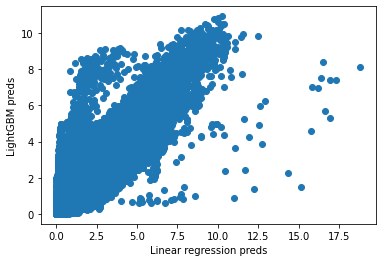

In [41]:
# Check if the 1st level models are uncorrelated enough
plt.scatter(caTrainDataLevel2[:, 0], caTrainDataLevel2[:, 1])
plt.xlabel('Linear regression preds')
plt.ylabel('LightGBM preds')
plt.show()

## Stack the models

### Simple convex mix
Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$


In [42]:
# alphas to try
ALPHAS_TO_TRY = np.linspace(0, 1, 1001)

In [43]:
"""
    Function name: LinearConvexMix
    
    Objective: Ensemble two first level models by using a simple linear convex mix
    
    Summary algorithmic description: Calculate linear convex mix of two models
    
    Input parameters: caMetaFeature : meta-features
                      fAlpha : parameter alpha
    
    Return : simple linear convex mix
    
    Date : 31/12/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def LinearConvexMix(caMetaFeature, fAlpha):
    # Return results of first level model
    return fAlpha * caMetaFeature[:, 0] + (1 - fAlpha) * caMetaFeature[:, 1]

In [44]:
# initialize the best alpha
fBestAlpha = -1
# initialize the best r2 score
fBestR2Score = -1e10
# Loop over all alpha values
for fAlpha in ALPHAS_TO_TRY:
    # predictions of linear convex mix
    caLinearConvexMixPrediction = LinearConvexMix(caTrainDataLevel2, fAlpha)
    # R2 score of predictions
    fR2Score = r2_score(dsTrainTargetLevel2, caLinearConvexMixPrediction.clip(*TARGET_RANGE))
    # better r2 score found
    if fR2Score > fBestR2Score:
        # better alpha found
        fBestAlpha = fAlpha
        # better r2 score found
        fBestR2Score = fR2Score

print('Best alpha: %f; Corresponding r2 score on train: %f' % (fBestAlpha, fBestR2Score))

Best alpha: 0.086000; Corresponding r2 score on train: 0.358484


In [45]:
# predictions on validation meta-features
caLinearConvexMixPrediction = LinearConvexMix(caValDataLevel2, fBestAlpha)

print('Validation RMSE for simple mix is %f' %  RMSEScore(dsValTarget, caLinearConvexMixPrediction.clip(*TARGET_RANGE)))

Validation RMSE for simple mix is 0.789439


### Linear regression

In [46]:
# Fit a linear regression model to the meta-features
oLinearRegression.fit(caTrainDataLevel2, dsTrainTargetLevel2)

print('Coefficient:            {}'.format(oLinearRegression.coef_))
print('Normalized Coefficient: {}'.format(oLinearRegression.coef_ / oLinearRegression.coef_.sum()))

Coefficient:            [0.12100603 0.93919969]
Normalized Coefficient: [0.11413448 0.88586552]


In [47]:
# predictions on validation meta-features
ca2ndLinearRegressionPrediction = oLinearRegression.predict(pd.DataFrame(caValDataLevel2)).clip(*TARGET_RANGE)
print('Validation RMSE for linear regression as 2nd level model is %f' % RMSEScore(dsValTarget.clip(*TARGET_RANGE), ca2ndLinearRegressionPrediction))

Validation RMSE for linear regression as 2nd level model is 0.790043


# Prediction for submission

In [48]:
# Load test data to merge ID for submission
dfTest = pd.read_csv(f'{DATA_FOLDER}/test.csv')

In [49]:
# print information about the index dtype and columns, non-null values and memory usage
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [50]:
# Fit linear model
oLinearRegression.fit(dfTrainData.values, dsTrainTarget)
# Predict test data
caLinearRegressionTestPredTarget = oLinearRegression.predict(dfTestData.values)

# Fit LightGBM on training data
oLGBModel = lgb.train(LGB_PARAMS, 
              lgb.Dataset(dfTrainData, label=dsTrainTarget.clip(*TARGET_RANGE)), 
              num_boost_round=LGB_ITERATION)
# Predict test data
caLGBTestPredTarget = oLGBModel.predict(dfTestData.values)

In [ ]:
# 2nd level feature validation matrix
caTestDataLevel2 = np.c_[caLinearRegressionTestPredTarget.clip(*TARGET_RANGE), caLGBTestPredTarget.clip(*TARGET_RANGE)]

In [52]:
# Ensemble two first level models by using a simple linear convex mix
caLinearConvexMixPrediction = LinearConvexMix(caTestDataLevel2, fBestAlpha)

In [53]:
# Predict test data
caTestPredTarget = caLinearConvexMixPrediction.clip(*TARGET_RANGE)
# length of prediction data
caTestPredTarget.shape

(214200,)

In [54]:
# test data
dfTestSubmission = dfAggregatedTrainTest[dsTrainTestDate==iTestMonth][['shop_id','item_id']]
# predictions of `item_cnt_month`
dfTestSubmission['item_cnt_month'] = caTestPredTarget
# Display the first 5 rows
dfTestSubmission.head()

,shop_id,item_id,item_cnt_month
10902329,2,30,0.020906
10902330,2,31,0.200140
10902331,2,32,0.184357
10902332,2,33,0.199119
10902333,2,38,0.016729


In [55]:
# Use test data to merge ID for submission
dfSubmission = dfTest.merge(dfTestSubmission, on=['shop_id','item_id'], how='left')
# # Display the first 5 rows
dfSubmission.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.572871
1,1,5,5320,0.432402
2,2,5,5233,0.981363
3,3,5,5232,0.498386
4,4,5,5268,1.885138


In [56]:
# print information about the index dtype and columns, non-null values and memory usage
dfSubmission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   shop_id         214200 non-null  int64  
 2   item_id         214200 non-null  int64  
 3   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 8.2 MB


In [57]:
# Dump to file
dfSubmission[['ID','item_cnt_month']].to_csv(f'{DATA_FOLDER}/submission.csv', header=True, index=False)